R-squared value: 0.9086274900883068
均方差: 0.006444418593204797
預測信用卡金額:
     年份  月份       預測信用卡金額
0  2023  10  1.799901e+11
1  2023  11  1.859726e+11
2  2023  12  1.926103e+11


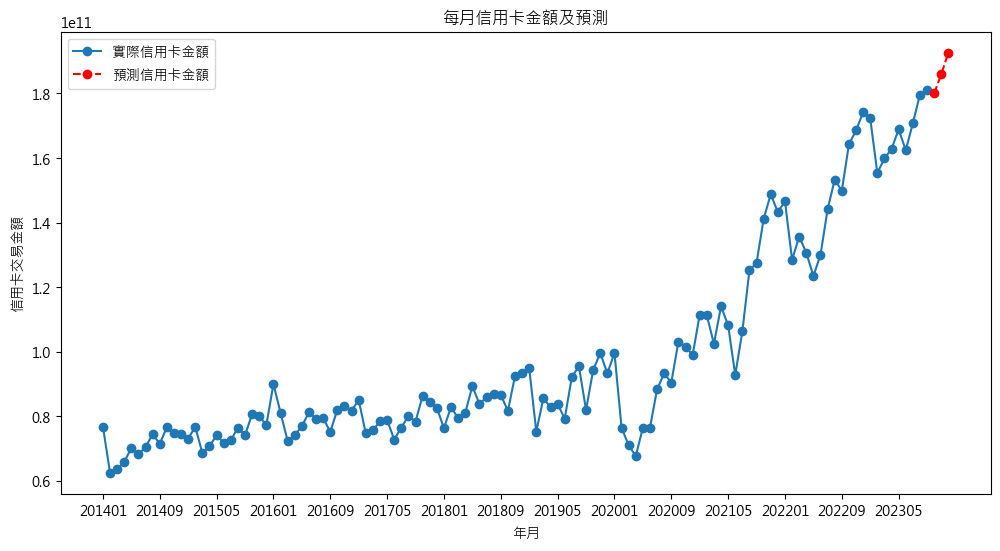

In [8]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "Microsoft JhengHei"

df = pd.read_csv("./processed_dataset.csv")

df["年月"] = pd.to_datetime(df["年"].astype(str) + df["月"].astype(str), format="%Y%m")
df["年月"] = df["年月"].dt.strftime("%Y%m")

# 按照年月分组，計算每年各個月份的信用卡消費金額
monthly_total_expenses = df.groupby(["年月"])["信用卡交易金額[新台幣]"].sum().reset_index()


# 將 '年月' 轉 datetime 取出年份和月份
monthly_total_expenses["年份"] = pd.to_datetime(
    monthly_total_expenses["年月"], format="%Y%m"
).dt.year
monthly_total_expenses["月份"] = pd.to_datetime(
    monthly_total_expenses["年月"], format="%Y%m"
).dt.month

X = monthly_total_expenses[["年份", "月份"]].astype(float)
y = monthly_total_expenses["信用卡交易金額[新台幣]"]

# 特徵轉換
degree = 2
poly = PolynomialFeatures(degree=degree)
X_poly = poly.fit_transform(X)

# 特徵縮放(MinMaxScaler)
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X_poly)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

# 建立模型
model = LinearRegression()
model.fit(X_scaled, y_scaled)

# 預測2023年10月、11月和12月的信用卡消費金額
next_months = pd.DataFrame({"年份": [2023] * 3, "月份": [10, 11, 12]})
next_months_poly = poly.transform(next_months)
next_months_scaled = scaler_X.transform(next_months_poly)

# 將預測的信用卡金額合併至DataFrame
next_months["預測信用卡金額"] = scaler_y.inverse_transform(
    model.predict(next_months_scaled).reshape(-1, 1)
).flatten()

# R平方與平均方差
r_squared = r2_score(y_scaled, model.predict(X_scaled))
print(f"R-squared value: {r_squared}")
mse = mean_squared_error(y_scaled, model.predict(X_scaled))
print(f"均方差: {mse}")

print("預測信用卡金額:")
print(next_months[["年份", "月份", "預測信用卡金額"]])

plt.figure(figsize=(12, 6))
plt.plot(monthly_total_expenses["年月"], y, marker="o", label="實際信用卡金額")
plt.plot(
    next_months["年份"].astype(str) + next_months["月份"].astype(str).str.zfill(2),
    next_months["預測信用卡金額"],
    marker="o",
    linestyle="--",
    color="red",
    label="預測信用卡金額",
)
plt.title("每月信用卡金額及預測")
plt.xlabel("年月")
plt.ylabel("信用卡交易金額")
plt.xticks(monthly_total_expenses["年月"][::8])  # 每8個標籤顯示一次
plt.legend()
plt.show()